# Gesture Recognition
- Project by Sachin Sen, Neha Sharma and Veenal Roland D'silva

<br>

### Problem Statement
To develop a gesture recognition algorithm for a smart TV to recognise five different gestures performed by the user without using a remote monitored via a web cam mounted on the tv.

<br>
List of gestures with corresponding actions:


| Gesture | Corresponding Action |
| --- | --- |
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

<br><br>
Length of each video: 30 frames (or images).



### Objectives:
1. **Generator**:  A generator that accepts a batch of videos as input without error and performs steps like cropping, resizing and normalization.

2. **Model**: A model that can evaluate inputs and classify the actions as required with minimalistic parameters.




In [ ]:
## Checking the GPU configuration

!nvidia-smi

Tue Jul  4 14:03:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#importing necessary libraries:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically every time the notebook gets run

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Mounting google drive to access test and validation data.

In [ ]:
## mounting google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Accesing the train and validation folders while setting the batch size.

In [ ]:
train_doc = np.random.permutation(open('//content/gdrive/MyDrive/Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('//content/gdrive/MyDrive/Gesture Recognition/Project_data/val.csv').readlines())
batch_size = 64

## Generator
Creeating fucntions that will be run in the generator for the necessary preprocessing of images

In [ ]:
def seq_Resize(image, y, z):
    h, w = image.shape

    # cropping image centrally
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [ ]:
def seq_Normalize(image):
    # applying normalization
    return image/255.0

def seq_dim(image, y, z):
    return seq_Normalize(seq_Resize(image, y, z))

In [ ]:
def generate_Batch(source_path, t, batch, batch_size, seq_detail):
    [x,y,z] = [len(seq_detail[0]),seq_detail[1], seq_detail[2]]
    img_idx = seq_detail[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate seq_dim function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = seq_dim(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = seq_dim(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = seq_dim(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

def generator(source_path, folder_list, batch_size, seq_detail):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield generate_Batch(source_path, t, batch, batch_size, seq_detail)

        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield generate_Batch(source_path, t, batch, batch_size, seq_detail)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '//content/gdrive/MyDrive/Gesture Recognition/Project_data/train'
val_path = '//content/gdrive/MyDrive/Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
def generate_Tensor(n_frames, dim_x=100, dim_y=100):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, dim_x, dim_y, 3]

# define image tensor size
seq_detail = generate_Tensor(16, 100, 100)
print ('# seq_detail =', seq_detail)

# seq_detail = [array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]


### Generator Validation

In [ ]:
# testing train batch generator
train_test_generator = generator(train_path, train_doc, batch_size, seq_detail)
train_test_batch_data, train_test_batch_labels = next(train_test_generator)
print(train_test_batch_data.shape)

# testing validation batch generator
val_test_generator = generator(val_path, val_doc, batch_size, seq_detail)
val_test_batch_data, val_test_batch_labels = next(val_test_generator)
print(val_test_batch_data.shape)

Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 64
(64, 16, 100, 100, 3)
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/val ; batch size = 64
(64, 16, 100, 100, 3)


In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_test_batch_data[15,8,:,:,:])
ax[1].imshow(val_test_batch_data[30,11,:,:,:])
plt.show()

In [ ]:
def history_plot(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("\nMax. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [ ]:
#importing necessary libraries
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

### Base Model

In [ ]:
#write your model here
def base_Model(seq_detail):
    seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

    model = Sequential([
        Conv3D(16, kernel_size = (5,5,5), activation='relu', input_shape=seq_shape),
        MaxPooling3D(pool_size = (2,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(32, kernel_size = (3,3,3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, kernel_size = (3,3,3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = base_Model(seq_detail)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                        

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model Callbacks Setup

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = path + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience=10,verbose=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR, earlystop]
#callbacks_list = [LR] #only used for hyperparameter testing models

### Creating a default model function to test batch zize, number of frames and image size

In [ ]:
def testParam(batch_size, n_frames, dim_x=100, dim_y=100):
    seq_detail = generate_Tensor(n_frames, dim_x, dim_y)
    print("Using frames as", seq_detail[0], "Image size", seq_detail[1], "x", seq_detail[1] )
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, seq_detail)
    val_generator = generator(val_path, val_doc, batch_size, seq_detail)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = base_Model(seq_detail)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                callbacks=callbacks_list, validation_data=val_generator,
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
testParam(batch_size=64, n_frames=30)

Using frames as [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - 5134s 500s/step - loss: 1.5038 - categorical_accuracy: 0.4585 - val_loss: 7.5425 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - 721s 67s/step - loss: 0.9553 - categorical_accuracy: 0.6166 - val_loss: 4.0438 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 3/3
11/11 [==============================] - 707s 66s/step - loss: 1.0857 - categorical_accuracy: 0.5929 - val_loss: 2.4343 - val_categorical_accuracy: 0.2679 - lr: 0.0010


In [ ]:
testParam(batch_size=64, n_frames=16)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - 755s 68s/step - loss: 1.4453 - categorical_accuracy: 0.4434 - val_loss: 4.9335 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - 289s 26s/step - loss: 0.9549 - categorical_accuracy: 0.6087 - val_loss: 6.0918 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/3
11/11 [==============================] - 295s 27s/step - loss: 1.0557 - categorical_accuracy: 0.6245 - val_loss: 3.7914 - val_categorical_accuracy: 0.2679 - lr: 0.0010


In [ ]:
testParam(batch_size=32, n_frames=30)

Using frames as [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] Image size 100 x 100
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 32
Epoch 1/3
21/21 [==============================] - 1630s 78s/step - loss: 1.5324 - categorical_accuracy: 0.4148 - val_loss: 9.2476 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - 1101s 52s/step - loss: 0.9786 - categorical_accuracy: 0.6211 - val_loss: 7.4625 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - 968s 46s/step - loss: 0.8920 - categorical_accuracy: 0.6628 - val_loss: 3.3135 - val_categorical_accuracy: 0.1250 - lr: 0.0010


In [ ]:
testParam(batch_size=32, n_frames=16)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29] Image size 100 x 100
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 32
Epoch 1/3
21/21 [==============================] - 715s 34s/step - loss: 1.5696 - categorical_accuracy: 0.4103 - val_loss: 2.0867 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - 488s 23s/step - loss: 0.9604 - categorical_accuracy: 0.6480 - val_loss: 2.4043 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - 450s 21s/step - loss: 0.9104 - categorical_accuracy: 0.6628 - val_loss: 2.5522 - val_categorical_accuracy: 0.3125 - lr: 0.0010


In [ ]:
testParam(batch_size=64, n_frames=16, dim_x=80, dim_y=80)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29] Image size 80 x 80
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - 493s 45s/step - loss: 1.6384 - categorical_accuracy: 0.4193 - val_loss: 1.6257 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - 203s 19s/step - loss: 1.0187 - categorical_accuracy: 0.6047 - val_loss: 1.8475 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 3/3
11/11 [==============================] - 191s 18s/step - loss: 1.0168 - categorical_accuracy: 0.6087 - val_loss: 1.7060 - val_categorical_accuracy: 0.2857 - lr: 0.0010


In [ ]:
testParam(batch_size=64, n_frames=16, dim_x=120, dim_y=120)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29] Image size 120 x 120
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - 1016s 93s/step - loss: 1.5009 - categorical_accuracy: 0.4419 - val_loss: 3.6776 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - 438s 41s/step - loss: 0.8794 - categorical_accuracy: 0.6561 - val_loss: 3.8026 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 3/3
11/11 [==============================] - 397s 36s/step - loss: 0.9071 - categorical_accuracy: 0.6443 - val_loss: 3.1122 - val_categorical_accuracy: 0.2321 - lr: 0.0010


In [ ]:
testParam(batch_size=32, n_frames=16, dim_x=80, dim_y=80)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29] Image size 80 x 80
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 32
Epoch 1/3
21/21 [==============================] - 490s 23s/step - loss: 1.5161 - categorical_accuracy: 0.4555 - val_loss: 1.8544 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - 323s 15s/step - loss: 0.9004 - categorical_accuracy: 0.6687 - val_loss: 2.2954 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - 292s 14s/step - loss: 0.8113 - categorical_accuracy: 0.6956 - val_loss: 4.0236 - val_categorical_accuracy: 0.0625 - lr: 0.0010


In [ ]:
testParam(batch_size=32, n_frames=16, dim_x=120, dim_y=120)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29] Image size 120 x 120
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 32
Epoch 1/3
21/21 [==============================] - 1021s 49s/step - loss: 1.4403 - categorical_accuracy: 0.4766 - val_loss: 6.2921 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - 690s 33s/step - loss: 0.9033 - categorical_accuracy: 0.6749 - val_loss: 3.1191 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - 608s 29s/step - loss: 0.7040 - categorical_accuracy: 0.7518 - val_loss: 2.3860 - val_categorical_accuracy: 0.1875 - lr: 0.0010




From the above observations, we can see that batch size is not impacting training time a lot but the number of frames and image size does impact training times.
- We will preferably use number of frame size as 16 to test models and then if an model is performing decently in the test phase we shall increase that number to 30 to check for difference in performance and accuracy.
- Image size of 100 X 100 is giving us a good output and hence we shall not change that unless required for better inferences

In [ ]:
#testing model save path
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
   os.mkdir(model_name)

filepath = path + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [LR]

In [ ]:
def testParam(batch_size, n_frames, dim_x=100, dim_y=100):
    seq_detail = generate_Tensor(n_frames, dim_x, dim_y)
    print("Using frames as", seq_detail[0], "Image size", seq_detail[1], "x", seq_detail[1] )
    global callbacks_list
    num_epochs = 1
    train_generator = generator(train_path, train_doc, batch_size, seq_detail)
    val_generator = generator(val_path, val_doc, batch_size, seq_detail)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = base_Model(seq_detail)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                callbacks=callbacks_list, validation_data=val_generator,
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
testParam(batch_size=32, n_frames=16, dim_x=80, dim_y=80)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29] Image size 80 x 80
Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/train ; batch size = 32
21/21 [==============================] - ETA: 0s - loss: 1.5871 - categorical_accuracy: 0.4284 Source path =  //content/gdrive/MyDrive/Gesture Recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to //content/gdrive/MyDrive/Gesture Recognition/Model/model_init_2023-06-2718_21_40.898887/model-00001-1.58715-0.42836-3.71788-0.24000.h5
21/21 [==============================] - 570s 27s/step - loss: 1.5871 - categorical_accuracy: 0.4284 - val_loss: 3.7179 - val_categorical_accuracy: 0.2400 - lr: 0.0010


The above path for model saving is working properly and shall be used to save all our models going forward.

### Model 1 - Frames - 16, Epoc - 20, Batch size - 64, image dimension- 100x100

In [ ]:
n_frames = 16
num_epochs = 20
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model1 = Sequential([
    Conv3D(16, kernel_size =(5,5,5), activation='relu', input_shape=seq_shape),
    MaxPooling3D(pool_size = (2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size =(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, kernel_size =(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 23, 23, 32)    0         
 3D)                                                             
                                                          

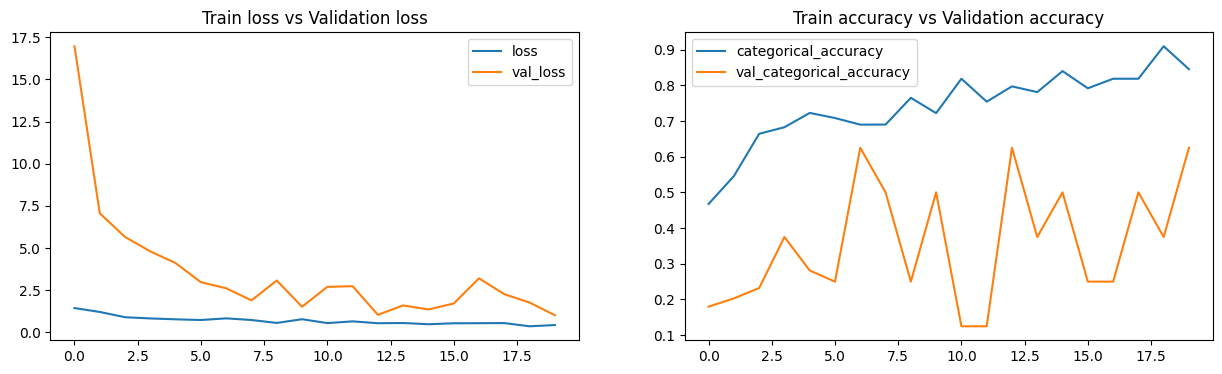

Max. Training Accuracy 0.9090909361839294
Max. Validaiton Accuracy 0.625


In [ ]:
history_plot(model1_history)

### Model 2 - Changing batch size and image size to check for difference in performance with a new architecture

In [ ]:
model_version = "model2"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience=7,verbose=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 20
batch_size = 32
dim_x = 80
dim_y = 80

seq_detail = generate_Tensor(n_frames, dim_x, dim_y)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model2 = Sequential([
    Conv3D(32, kernel_size =(3,3,3), activation='relu', input_shape=seq_shape),
    Conv3D(64, kernel_size =(3,3,3), activation='relu'),
    MaxPooling3D(pool_size = (2,2,2), padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    Conv3D(128, kernel_size =(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    Conv3D(256, kernel_size=(1, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    Conv3D(512, kernel_size=(1, 3, 3), activation='relu'),
    Conv3D(512, kernel_size=(1, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(5, activation='softmax')
    ], name = "Model_2")
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 14, 78, 78, 32)    2624      
                                                                 
 conv3d_28 (Conv3D)          (None, 12, 76, 76, 64)    55360     
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 6, 38, 38, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 6, 38, 38, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 6, 38, 38, 64)     0         
                                                                 
 conv3d_29 (Conv3D)          (None, 4, 36, 36, 128)    2213

In [ ]:
history_plot(model2_history)

Max. Training Accuracy 0.9103641510009766
Max. Validaiton Accuracy 0.5


### Model 3 - Decreasing the dropout value to every layer and one convolutional layer in the model while increasing the number of epochs to 30

In [ ]:
model_version = "model_3"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 10,verbose=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 30
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model3 = Sequential([
    Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=seq_shape),
    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv3D(128, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv3D(256, kernel_size=(1, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
    ], name="Model_3")

model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 98, 98, 32)    2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 96, 96, 64)    55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 48, 48, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 48, 48, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 48, 48, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 46, 46, 128)    2213

In [ ]:
history_plot(model3_history)


Max. Training Accuracy 0.9893048405647278
Max. Validaiton Accuracy 0.625


### Model 4: Changing flatten to GlobalAverage pooling to deal with overfitting

In [ ]:
model_version = "model_4"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 10,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 30
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model4 = Sequential([
    Conv3D(16, kernel_size =(3,3,3), padding='same', activation='relu', input_shape=seq_shape),
    MaxPooling3D(pool_size = (2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size =(3,3,3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, kernel_size =(3,3,3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, kernel_size =(3,3,3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    GlobalAveragePooling3D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="Model_4")
model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 8, 50, 50, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                           

In [ ]:
history_plot(model4_history)


Max. Training Accuracy 0.7219251394271851
Max. Validaiton Accuracy 0.5


### Model 5: Switching BatchNormalization before MaxPooling while keeping the GlobalAveragepooling3D layer and changing the architecture, increasing epochs to 50 and early stopping patience to 12

In [ ]:
model_version = "model_5"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 12,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 50
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model5 = Sequential([
    Conv3D(16, kernel_size =(2,2,2), padding='same', activation='relu', input_shape=seq_shape),
    BatchNormalization(),
    MaxPooling3D(pool_size = (2,2,2)),

    Conv3D(32, kernel_size =(2,2,2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, kernel_size =(2,2,2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, kernel_size =(2,2,2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    GlobalAveragePooling3D(),
    Dense(256, activation='relu'),

    Dense(128, activation='relu'),

    Dense(5, activation='softmax')
], name="Model_5")
model5.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 100, 100, 16)  400       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 batch_normalization_11 (Bat  (None, 8, 50, 50, 32)    128       
 chNormalization)                                                
                                                           

In [ ]:
history_plot(model5_history)


Max. Training Accuracy 0.8983957171440125
Max. Validaiton Accuracy 0.5


### Model 6: Switching Model architecture and increasing parameters to check performance

In [ ]:
model_version = "model_6"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 12,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 50
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model6 = Sequential([
    Conv3D(32, kernel_size =(3,3,3), activation='relu', input_shape=seq_shape),
    Conv3D(64, kernel_size =(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv3D(128, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv3D(256, kernel_size=(1, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling3D(),
    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(5, activation='softmax')
], name="Model_6")
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 14, 98, 98, 32)    2624      
                                                                 
 conv3d_5 (Conv3D)           (None, 12, 96, 96, 64)    55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 48, 48, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 6, 48, 48, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 6, 48, 48, 64)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 4, 46, 46, 128)    2213

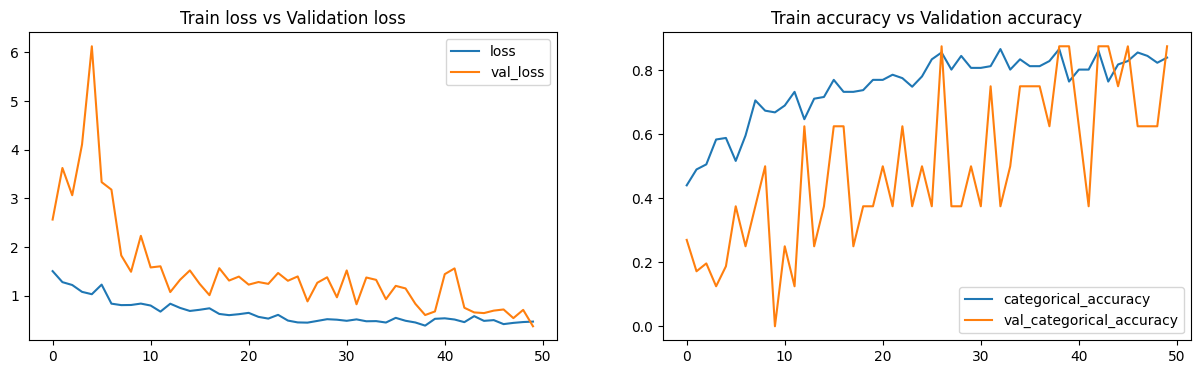


Max. Training Accuracy 0.866310179233551
Max. Validaiton Accuracy 0.875


In [ ]:
history_plot(model6_history)

### Model 7: Changing global average pooling to flatten again while BatchNormalizing before Maxpooling

In [ ]:
model_version = "model_7"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 12,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 50
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model7 = Sequential([
    Conv3D(16, kernel_size =(3,3,3), activation='relu', padding='same', input_shape=seq_shape),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(32, kernel_size =(3,3,3), activation = "relu", padding = "same"),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(64, kernel_size =(3,3,3), activation = "relu", padding = "same"),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(128, kernel_size =(3,3,3), activation = "relu", padding = "same"),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Flatten(),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="Model_7")
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 16, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 50, 50, 32)    128       
 hNormalization)                                                 
                                                           

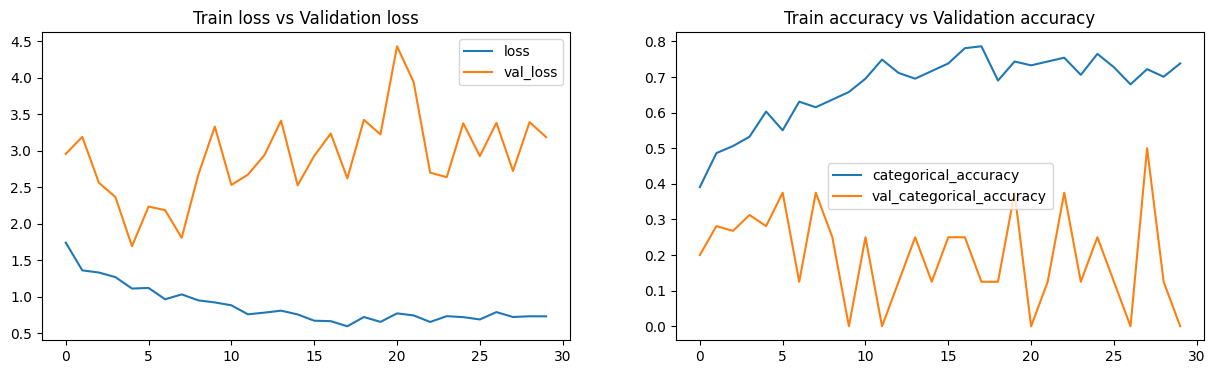


Max. Training Accuracy 0.7860962748527527
Max. Validaiton Accuracy 0.5


In [ ]:
history_plot(model7_history)

### Model 8: Switching Model architecture to Conv2D+LSTM

In [ ]:
model_version = "model_8"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 15,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 50
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model_8 = Sequential([
    TimeDistributed(Conv2D(16, kernel_size =(3,3), padding='same', activation='relu'), input_shape=seq_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),

    TimeDistributed(Conv2D(32, kernel_size =(3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),

    TimeDistributed(Conv2D(64, kernel_size =(3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),

    TimeDistributed(Conv2D(128, kernel_size =(3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),

    TimeDistributed(Conv2D(256, kernel_size =(3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="Model_8")
model_8.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_8.summary())

model_8_history = model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 16, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 16, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 50, 50, 32)   128 

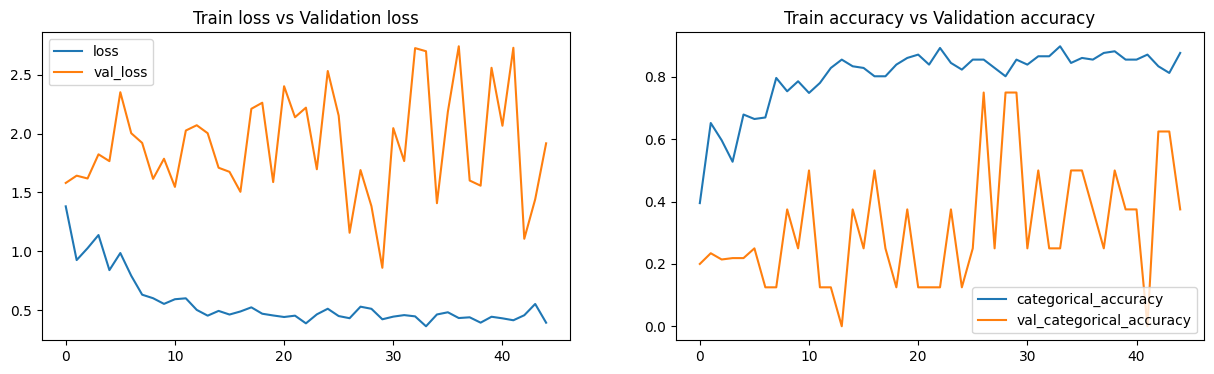


Max. Training Accuracy 0.8983957171440125
Max. Validaiton Accuracy 0.75


In [ ]:
history_plot(model_8_history)

### Model 9: Using TimeDistributed Conv2D + GRU

In [ ]:
model_version = "model_9"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 15,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 50
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model_9 = Sequential([
    TimeDistributed(Conv2D(32, kernel_size = (3,3), activation='relu'), input_shape=seq_shape),
    TimeDistributed(MaxPooling2D(pool_size = (2,2))),
    BatchNormalization(),

    TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    BatchNormalization(),

    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),

    GRU(128),
    BatchNormalization(),

    Dense(5, activation='softmax')
], name="Model_9")
model_9.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_9.summary())

model_9_history = model_9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 98, 98, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 16, 49, 49, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 47, 47, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 23, 23, 64)   0   

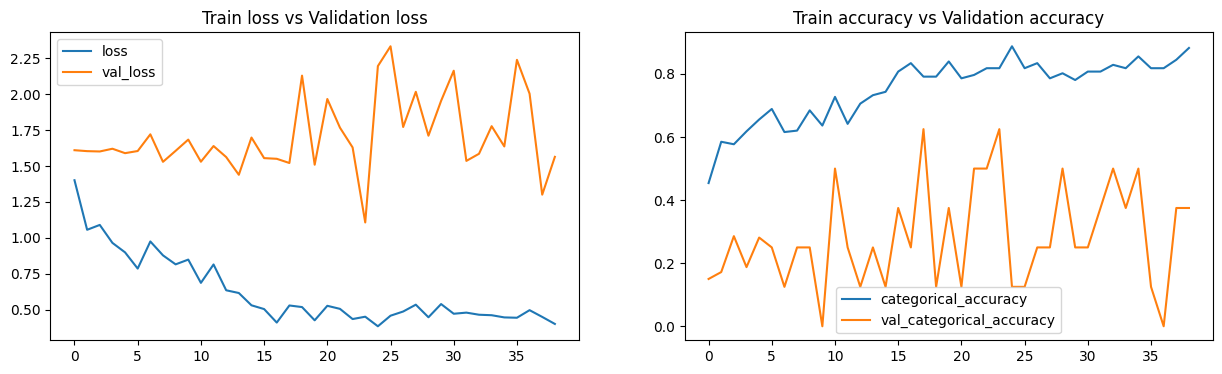


Max. Training Accuracy 0.8877005577087402
Max. Validaiton Accuracy 0.625


In [ ]:
history_plot(model_9_history)

### Model 10 : Using TimeDistributed Conv2D + GRU while adding dropout layers

In [ ]:
model_version = "model_10"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 20,verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 80
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model_10 = Sequential([
    TimeDistributed(Conv2D(32, kernel_size = (3,3), activation='relu'), input_shape=seq_shape),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),
    BatchNormalization(),
    Dropout(0.2),

    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),
    BatchNormalization(),
    Dropout(0.2),

    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    Dropout(0.2),

    GRU(128),
    BatchNormalization(),

    Dense(5, activation='softmax')
    ], name="Model_10")
model_10.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_10.summary())

model_10_history = model_10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 16, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 16, 49, 49, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 16, 49, 49, 32)    0         
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 47, 47, 64)   18496     
 stributed)                                               

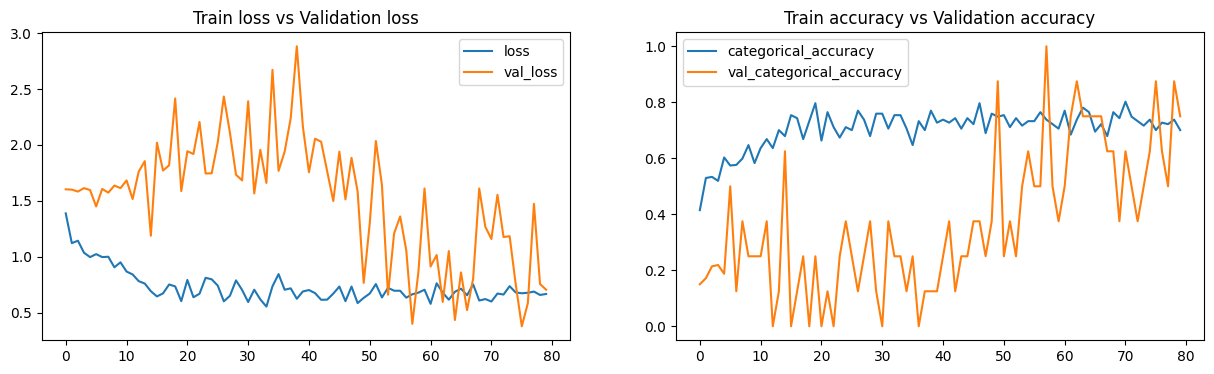


Max. Training Accuracy 0.8021390438079834
Max. Validaiton Accuracy 1.0


In [ ]:
history_plot(model_10_history)

### Model 11: Using TimeDistributed Conv2D

In [ ]:
model_version = "model_11"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 20, verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 4)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 80
batch_size = 64

seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model_11 = Sequential([
    TimeDistributed(Conv2D(32, kernel_size = (3,3), activation='relu'), input_shape=seq_shape),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),
    BatchNormalization(),

    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),
    BatchNormalization(),

    TimeDistributed(Conv2D(128, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D(pool_size =(2,2))),
    BatchNormalization(),

    GlobalAveragePooling3D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
    ], name="Model_11")
model_11.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_11.summary())

model_11_history = model_11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 16, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 16, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 16, 49, 49, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_26 (TimeDi  (None, 16, 47, 47, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 16, 23, 23, 64)   0  

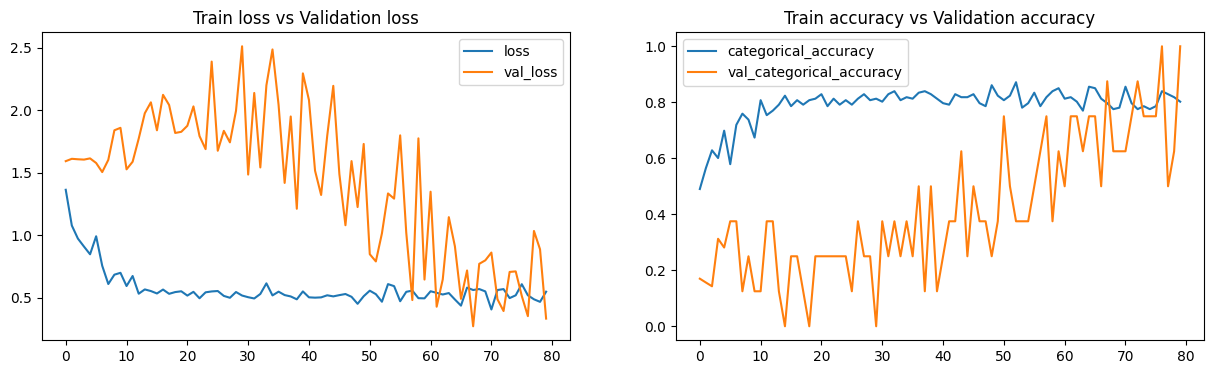


Max. Training Accuracy 0.8716577291488647
Max. Validaiton Accuracy 1.0


In [ ]:
history_plot(model_11_history)

### Model_12: Using TimeDistributed + ConvLSTM2D

In [ ]:
model_version = "model_12"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 20, verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 5)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
n_frames = 16
num_epochs = 50
batch_size = 32


seq_detail = generate_Tensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, seq_detail)
val_generator = generator(val_path, val_doc, batch_size, seq_detail)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

seq_shape = (len(seq_detail[0]), seq_detail[1], seq_detail[2], seq_detail[3])

model_12 = Sequential([
    TimeDistributed(Conv2D(8, kernel_size =(3,3), activation='relu'), input_shape=seq_shape),
    BatchNormalization(),

    TimeDistributed(Conv2D(16, kernel_size =(3,3), activation='relu')),
    BatchNormalization(),

    ConvLSTM2D(8, kernel_size = 3),
    BatchNormalization(),

    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),

    Dense(5, activation='softmax')
    ], name="Model_12")
model_12.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_12.summary())

model_12_history = model_12.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "Model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 98, 98, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 98, 98, 8)    32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 96, 96, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 16, 96, 96, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 94, 94, 8)         694

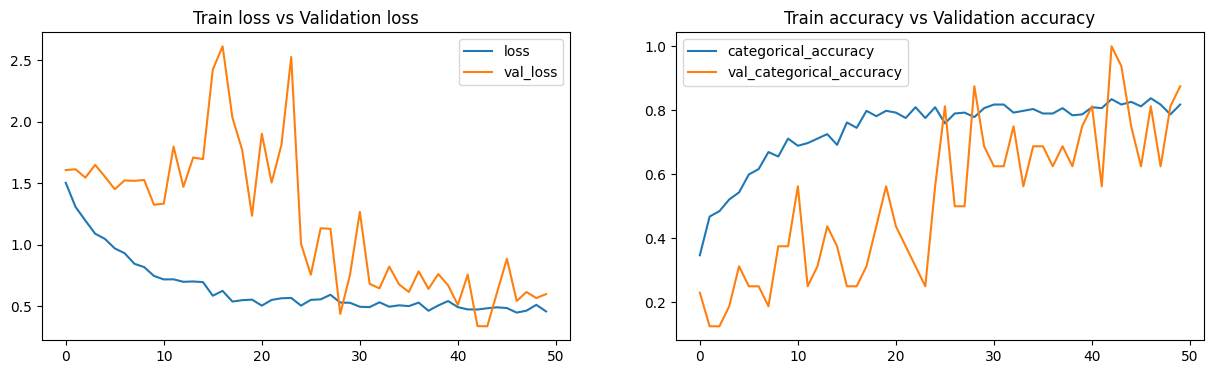


Max. Training Accuracy 0.83753502368927
Max. Validaiton Accuracy 1.0


In [ ]:
history_plot(model_12_history)

Training model for further 30 epochs to see if performance improves

In [ ]:
model_version = "model_12_v2"
model_name = model_version + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

path = "//content/gdrive/MyDrive/Gesture Recognition/Model/"

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = path + model_name + model_version + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

earlystop = EarlyStopping( monitor="val_loss", patience = 20, verbose=1, start_from_epoch = 15)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience = 5)

callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
num_epochs = 30
model_12_history = model_12.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
           callbacks=callbacks_list, validation_data=val_generator,
           validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.4603 - categorical_accuracy: 0.8375 
Epoch 1: saving model to //content/gdrive/MyDrive/Gesture Recognition/Model/model_12_v2_init_2023-07-0401_49_56.272091/model_12_v2-00001-0.46031-0.83754-0.39929-0.93750.h5
21/21 [==============================] - 494s 23s/step - loss: 0.4603 - categorical_accuracy: 0.8375 - val_loss: 0.3993 - val_categorical_accuracy: 0.9375 - lr: 1.6000e-06
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.4617 - categorical_accuracy: 0.8375 
Epoch 2: saving model to //content/gdrive/MyDrive/Gesture Recognition/Model/model_12_v2_init_2023-07-0401_49_56.272091/model_12_v2-00002-0.46166-0.83754-0.51900-0.75000.h5
21/21 [==============================] - 495s 23s/step - loss: 0.4617 - categorical_accuracy: 0.8375 - val_loss: 0.5190 - val_categorical_accuracy: 0.7500 - lr: 1.6000e-06
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.4656 - categorical_accuracy:

In [ ]:
#TPU timed out and hence had to stop training as is

Final model to be used shall be model 12: epoch 53 (Model_12_v2-00003...) because we are achieving good accuracy while val_loss is slightly higher than loss with the model having minimal parameters